# Task 2

input layer, hidden recurrent layer w tanh activation, output layer has softmax function for classification
check accuracy for classification and MSE for # predictions

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import files

# all_stocks_5yr.csv
uploaded = files.upload()

Saving all_stocks_5yr.csv to all_stocks_5yr (3).csv


In [ ]:
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

stock_df = df[df['Name'] == 'AAPL'][['close']]

scaler = MinMaxScaler(feature_range=(-1, 1))
stock_df['close'] = scaler.fit_transform(stock_df)

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 50
X, y = create_sequences(stock_df.values, seq_length)

X_train, y_train = torch.Tensor(X), torch.Tensor(y)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# rnn model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

model = SimpleRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# train
num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/50], Loss: 0.001564
Epoch [20/50], Loss: 0.001226
Epoch [30/50], Loss: 0.001526
Epoch [40/50], Loss: 0.000705
Epoch [50/50], Loss: 0.000790


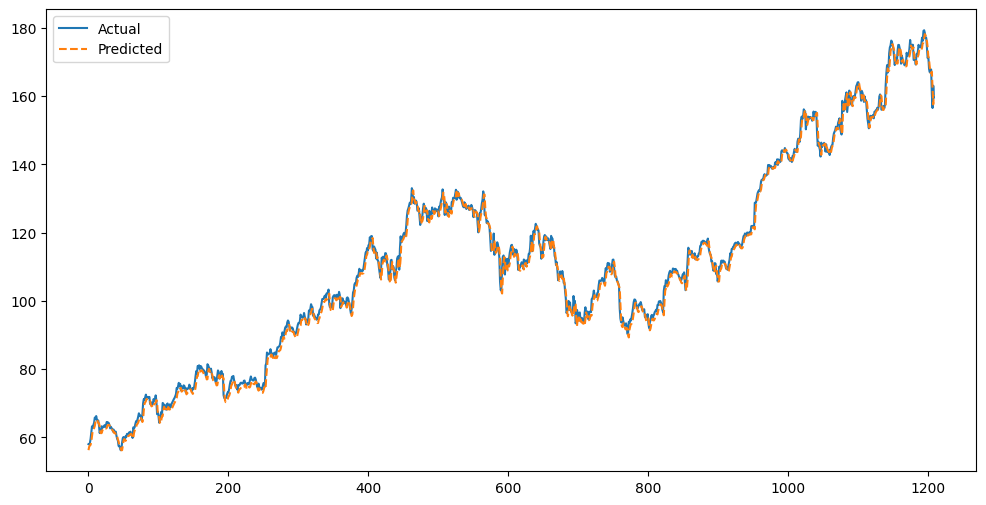

In [ ]:
# eval performance
model.eval()
with torch.no_grad():
    test_preds = model(X_train).numpy()

test_preds = scaler.inverse_transform(test_preds)
actual_values = scaler.inverse_transform(y_train.numpy())

plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual")
plt.plot(test_preds, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()

LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# train
lstm_model = LSTMModel(input_size=1, hidden_size=50, output_size=1, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

num_epochs = 50
lstm_train_losses = []
for epoch in range(num_epochs):
    lstm_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    lstm_train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/50], Loss: 0.002120
Epoch [20/50], Loss: 0.002228
Epoch [30/50], Loss: 0.001336
Epoch [40/50], Loss: 0.001910
Epoch [50/50], Loss: 0.002090


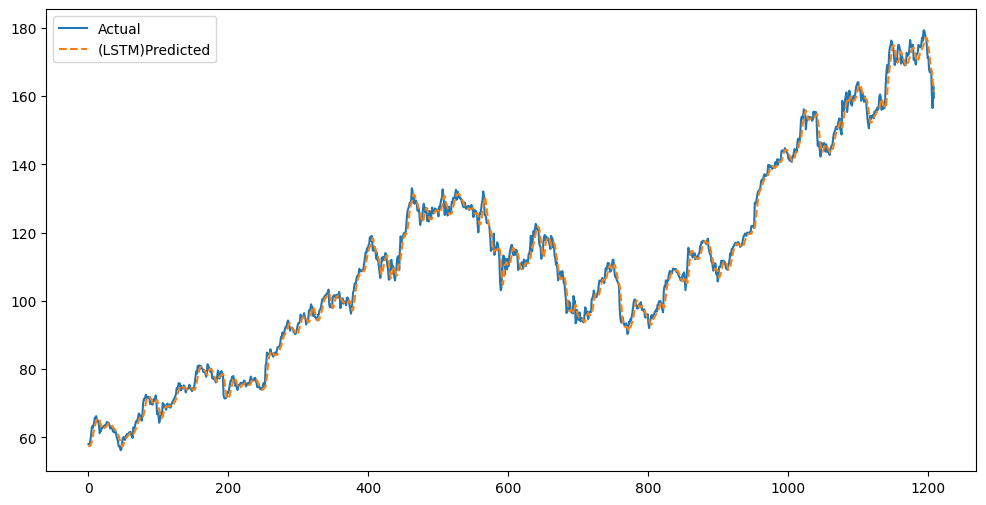

In [ ]:
# eval performance
lstm_model.eval()
with torch.no_grad():
    lstm_preds = lstm_model(X_train).numpy()

lstm_preds = scaler.inverse_transform(lstm_preds)
actual_values = scaler.inverse_transform(y_train.numpy())

plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual")
plt.plot(lstm_preds, label="(LSTM)Predicted", linestyle="dashed")
plt.legend()
plt.show()

GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# train
gru_model = GRUModel(input_size=1, hidden_size=50, output_size=1, num_layers=2)
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

gru_train_losses = []
for epoch in range(num_epochs):
    gru_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = gru_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    gru_train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/50], Loss: 0.001377
Epoch [20/50], Loss: 0.000871
Epoch [30/50], Loss: 0.001083
Epoch [40/50], Loss: 0.001008
Epoch [50/50], Loss: 0.000929


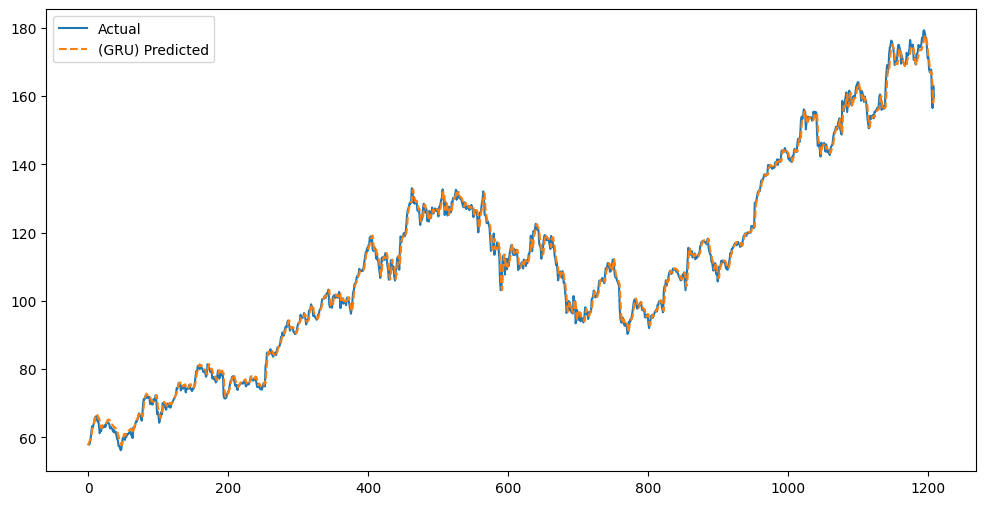

In [ ]:
# eval performance
gru_model.eval()
with torch.no_grad():
    gru_preds = gru_model(X_train).numpy()

gru_preds = scaler.inverse_transform(gru_preds)
actual_values = scaler.inverse_transform(y_train.numpy())

plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual")
plt.plot(gru_preds, label="(GRU) Predicted", linestyle="dashed")
plt.legend()
plt.show()

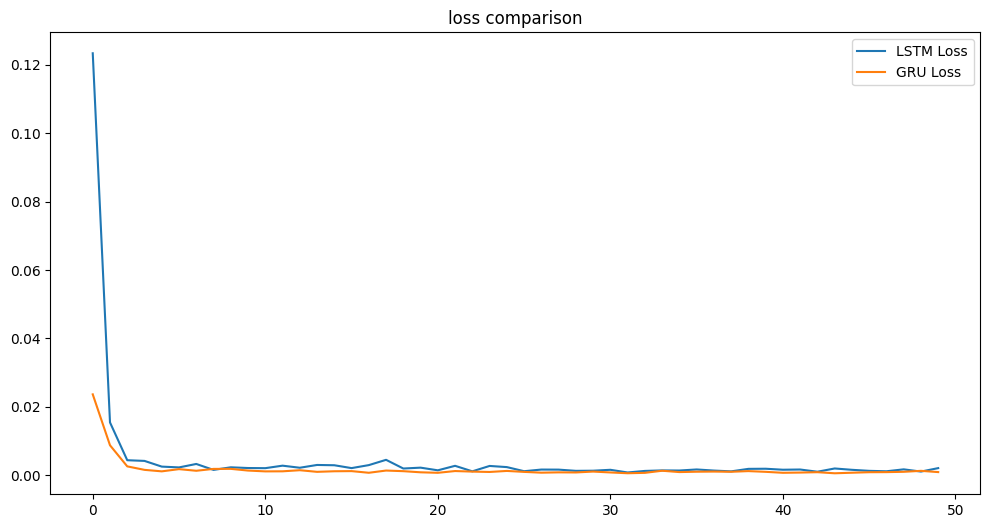

In [ ]:
# compare training losses
plt.figure(figsize=(12, 6))
plt.plot(lstm_train_losses, label="LSTM Loss")
plt.plot(gru_train_losses, label="GRU Loss")
plt.legend()
plt.title("loss comparison")
plt.show()

the major differences between the 3 implementations is how they capture the long term dependencies (and also performance). RNN doesn't really handle long-term memory well because of the vanishing gradient problem, LSTM handles long-term dependencies better. GRUs are like LSTMs but has a more simple structure. These exist because RNNs doesn't handle the vanishing gradient problem well

traditional feed-forward network isn't good for solving the same problem because it doesn't look at the temporal dependencies between data points.

# Task 3

Chose GloVe because it has a good balance of the quality and size.

In [ ]:
# https://nlp.stanford.edu/data/glove.6B.zip
uploaded = files.upload()
uploaded_files = os.listdir()
print(uploaded_files)

In [ ]:
def load_glove_embeddings(glove_file_path):
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
print("GloVe embeddings loaded successfully.")

In [ ]:
def get_embedding(word, embeddings):
    if word in embeddings:
        return embeddings[word]
    else:
        return np.zeros(embeddings['the'].shape)

word_1 = input("Enter first word: ").lower()
word_2 = input("Enter second word: ").lower()

embedding_1 = get_embedding(word_1, glove_embeddings)
embedding_2 = get_embedding(word_2, glove_embeddings)

print(f"Embedding of '{word_1}': {embedding_1}")
print(f"Embedding of '{word_2}': {embedding_2}")

In [ ]:
from scipy.spatial.distance import cosine

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

sim = cosine_similarity(embedding_1, embedding_2)
print(f"Cosine similarity between '{word_1}' and '{word_2}': {sim:.4f}")

cosine similarity is used for similarity between 2 vectors (regardless magnitude), which is really useful in these word embedding spaces

In [ ]:
def batch_cosine_similarity(word_pairs, embeddings):
    similarities = []
    for word1, word2 in word_pairs:
        emb1 = get_embedding(word1, embeddings)
        emb2 = get_embedding(word2, embeddings)
        sim = cosine_similarity(emb1, emb2)
        similarities.append((word1, word2, sim))
    return similarities

word_pairs = [('king', 'queen'), ('man', 'woman'), ('cat', 'dog'), ('apple', 'banana')]
similarities = batch_cosine_similarity(word_pairs, glove_embeddings)
print("Cosine Similarity between word pairs:")
for word1, word2, sim in similarities:
    print(f"Cosine similarity between {word1} and {word2}: {sim:.4f}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_word_embeddings(words, embeddings):
    vectors = [get_embedding(word, embeddings) for word in words]
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o')

    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=12)

    plt.title("Word Embeddings Visualized (PCA)")
    plt.show()

words_to_visualize = ['king', 'queen', 'man', 'woman', 'cat', 'dog', 'apple', 'banana']
plot_word_embeddings(words_to_visualize, glove_embeddings)

In [ ]:
from nltk.corpus import wordnet as wn

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def word_entropy_based_dissimilarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)

    if synsets1 and synsets2:
        entropy_1 = -sum([lemma.count() * np.log(lemma.count()) for lemma in synsets1[0].lemmas()])
        entropy_2 = -sum([lemma.count() * np.log(lemma.count()) for lemma in synsets2[0].lemmas()])
        return abs(entropy_1 - entropy_2)
    else:
        return np.inf

def compute_custom_dissimilarity(word1, word2, embeddings, metric="cosine"):
    vec1 = get_embedding(word1, embeddings)
    vec2 = get_embedding(word2, embeddings)

    if metric == "cosine":
        return cosine_similarity(vec1, vec2)
    elif metric == "euclidean":
        return euclidean_distance(vec1, vec2)
    elif metric == "entropy":
        return word_entropy_based_dissimilarity(word1, word2)
    else:
        raise ValueError("Unknown metric")

word1 = 'king'
word2 = 'queen'
metrics = ['cosine', 'euclidean', 'entropy']

for metric in metrics:
    result = compute_custom_dissimilarity(word1, word2, glove_embeddings, metric)
    print(f"{metric.capitalize()} dissimilarity between '{word1}' and '{word2}': {result:.4f}")


In [ ]:
import seaborn as sns

def plot_word_ranking(word, words, embeddings, metric="cosine"):
    dissimilarities = []
    for w in words:
        dissimilarity = compute_custom_dissimilarity(word, w, embeddings, metric)
        dissimilarities.append((w, dissimilarity))

    dissimilarities.sort(key=lambda x: x[1], reverse=True)
    words_sorted = [item[0] for item in dissimilarities]
    dissimilarities_sorted = [item[1] for item in dissimilarities]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=dissimilarities_sorted, y=words_sorted, palette="Blues_d")
    plt.title(f"Ranking of words based on {metric} dissimilarity to '{word}'")
    plt.xlabel(f"{metric} Dissimilarity")
    plt.show()

words_to_rank = ['queen', 'man', 'woman', 'cat', 'dog', 'apple', 'banana']
plot_word_ranking('king', words_to_rank, glove_embeddings, 'cosine')
plot_word_ranking('king', words_to_rank, glove_embeddings, 'euclidean')
plot_word_ranking('king', words_to_rank, glove_embeddings, 'entropy')